In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
normalized_scan_100610_full = np.load('normalized_scan_100610_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_100610 = np.loadtxt(config.data_folder2 + '/100610/bvals')

In [6]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_100610_sub = bvals_all_100610[rand_sub_bval_indice_100206]*1e-3

In [7]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_100610_sub = normalized_scan_100610_full[:, rand_sub_bval_indice_100206]

In [8]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_100610_sub = np.where(bvals_100610_sub != 0.005)[0]

In [9]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_100610_sub_no_b5 = bvals_100610_sub[big_b_indice_100610_sub]

In [10]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_100610_sub_no_b5 = normalized_scan_100610_sub[:, big_b_indice_100610_sub]

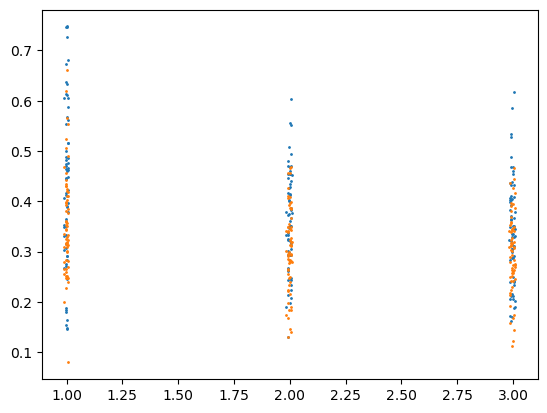

In [11]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_100610_sub_no_b5, normalized_scan_100610_sub_no_b5[42,:], "o", markersize = 1)

In [12]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_100610_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [13]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_100610_sub = n_100610_all[:, rand_sub_bval_indice_100206]
n_100610_sub_no_b5 = n_100610_sub[:,big_b_indice_100610_sub].T
print(n_100610_sub_no_b5.shape)

b_values_100610_sub_no_b5 = torch.FloatTensor(bvals_100610_sub_no_b5)
gradient_directions_100610_sub_no_b5 = torch.FloatTensor(n_100610_sub_no_b5)

(195, 3)
(195, 3)


In [14]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [18]:
val_set = torch.from_numpy(normalized_scan_100610_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 195])
<class 'torch.Tensor'>


In [15]:
bvals_num = len(b_values_100206_sub_no_b5)
net = network.BallStickNet(bvals_num)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [ ]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []

counter = 0

# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch, gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    net.eval()
    running_val_loss = 0.
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = net(val_set, gradient_directions_100610_sub_no_b5, b_values_100610_sub_no_b5)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss += val_loss.item()
    val_loss_list.append(running_val_loss)
    print("Validation Loss: {}".format(running_val_loss))

    # if running_train_loss < best_train_loss and running_val_loss < best_val_loss:
    if running_train_loss < best_train_loss:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best_train_loss = running_train_loss
        # best_val_loss = running_val_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best training loss: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.66it/s]


Loss: 425.56741442671046; Average Loss: 0.058233089002012926
Validation Loss: 0.13581740856170654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.13it/s]


Loss: 424.8739467225969; Average Loss: 0.05813819741688518
Validation Loss: 0.13630157709121704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.30it/s]


Loss: 425.3317204010673; Average Loss: 0.05820083749330423
Validation Loss: 0.136353999376297
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.57it/s]


Loss: 425.2294448777102; Average Loss: 0.058186842484634675
Validation Loss: 0.13629591464996338
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.68it/s]


Loss: 424.2852906328626; Average Loss: 0.058057647869849835
Validation Loss: 0.1365469992160797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.34it/s]


Loss: 424.1936270254664; Average Loss: 0.05804510495696037
Validation Loss: 0.13657718896865845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.89it/s]


Loss: 424.41116742184386; Average Loss: 0.05807487238941487
Validation Loss: 0.13666386902332306
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.65it/s]


Loss: 423.5890000574291; Average Loss: 0.05796237001333184
Validation Loss: 0.1366160362958908
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.79it/s]


Loss: 424.4010084401816; Average Loss: 0.05807348227150816
Validation Loss: 0.13724926114082336
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.84it/s]


Loss: 423.38449413655326; Average Loss: 0.057934386170847466
Validation Loss: 0.13764196634292603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▉                                                                                                                                                           | 135/7308 [00:03<00:53, 135.27it/s]

X_batch: 
torch.Size([128, 195])
tensor([[0.1637, 0.0724, 0.0398,  ..., 0.1492, 0.0223, 0.0608],
        [0.5169, 0.2245, 0.2200,  ..., 0.5702, 0.1811, 0.3322],
        [0.2820, 0.1644, 0.1531,  ..., 0.2382, 0.1158, 0.1275],
        ...,
        [0.5709, 0.2782, 0.1941,  ..., 0.4437, 0.1299, 0.2368],
        [0.7335, 0.3404, 0.4565,  ..., 0.4652, 0.3572, 0.3235],
        [0.4126, 0.2411, 0.2331,  ..., 0.5292, 0.1334, 0.3073]])
X_pred: 
torch.Size([128, 195])
tensor([[0.1518, 0.0654, 0.0472,  ..., 0.1476, 0.0512, 0.0645],
        [0.5279, 0.3252, 0.2147,  ..., 0.5171, 0.2253, 0.3253],
        [0.2123, 0.1039, 0.0751,  ..., 0.2064, 0.0808, 0.1032],
        ...,
        [0.4565, 0.2763, 0.1828,  ..., 0.4435, 0.2014, 0.2664],
        [0.5572, 0.3724, 0.2890,  ..., 0.5571, 0.2841, 0.3889],
        [0.4476, 0.2513, 0.1647,  ..., 0.4415, 0.1684, 0.2551]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.79it/s]


Loss: 423.7437743828632; Average Loss: 0.05798354876612797
Validation Loss: 0.13740910589694977
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.08it/s]


Loss: 423.84068998368457; Average Loss: 0.057996810342595045
Validation Loss: 0.13762091100215912
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.29it/s]


Loss: 423.8783261938952; Average Loss: 0.05800196034399223
Validation Loss: 0.13760021328926086
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.01it/s]


Loss: 423.73726375820115; Average Loss: 0.0579826578760538
Validation Loss: 0.1379467248916626
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.91it/s]


Loss: 423.7134781596251; Average Loss: 0.05797940314171115
Validation Loss: 0.13780577480793
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.74it/s]


Loss: 423.68056703032926; Average Loss: 0.05797489970311019
Validation Loss: 0.13810035586357117
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.06it/s]


Loss: 422.9999526082538; Average Loss: 0.057881766914101504
Validation Loss: 0.1384357511997223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.14it/s]


Loss: 422.907572675962; Average Loss: 0.057869125981932404
Validation Loss: 0.13735109567642212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.97it/s]


Loss: 423.1045785890892; Average Loss: 0.05789608355077849
Validation Loss: 0.13804008066654205
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.35it/s]


Loss: 423.1157062649727; Average Loss: 0.05789760622126063
Validation Loss: 0.13855327665805817
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.72it/s]


Loss: 422.9615871049464; Average Loss: 0.057876517118903445
Validation Loss: 0.13836883008480072
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.34it/s]


Loss: 423.4193787360564; Average Loss: 0.057939159651896055
Validation Loss: 0.13779902458190918
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 4


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6408/7308 [00:45<00:05, 154.59it/s]

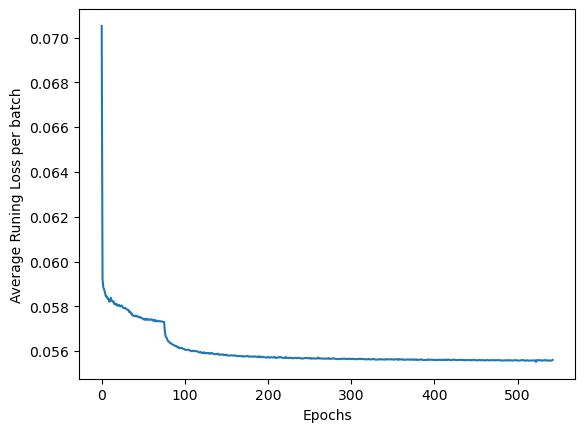

In [16]:
epoch_arr = np.arange(0, len(avg_train_loss_list))
loss_arr = np.array(avg_train_loss_list)
plt.plot(avg_train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [17]:
torch.save(final_model, 'model_100206_11g_04_retrain1.pt')

In [3]:
scan_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/data.nii.gz')
mask_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/nodif_brain_mask.nii.gz')
scan_dimension = scan_100610.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100610_long = np.reshape(scan_100610, (x*y*z, b))

mask_100610_long = np.reshape(mask_100610, (x*y*z, 1))

In [5]:
indices_beginning_0_all = np.where(scan_100610_long[:, 0] == 0)[0]
print(len(indices_beginning_0_all))

2313337


In [6]:
mask_100610_long_pro = np.copy(mask_100610_long)
mask_100610_long_pro[indices_beginning_0_all] = 0

print(len(np.where(mask_100610_long_pro == 0)[0]))

2778196


In [7]:
scan_100610_long_no_background = process_data.remove_background(scan_100610_long, mask_100610_long_pro)

In [8]:
bvals_all_100610 = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [9]:
S0_100610 = process_data.get_S0(scan_100610_long_no_background, bvals_all_100610)

In [11]:
normalized_scan_100610_full = scan_100610_long_no_background / S0_100610

In [14]:
np.save("normalized_scan_100610_full.npy",normalized_scan_100610_full)